In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import contextily as ctx

df = pd.read_csv('data/testing_no_null.csv', parse_dates=['Trip Start Timestamp', 'Trip End Timestamp'])
df = df.dropna(subset=['Pickup Centroid Longitude', 'Pickup Centroid Latitude'])
df['pickup_hour'] = df['Trip Start Timestamp'].dt.hour
df['dropoff_hour'] = df['Trip End Timestamp'].dt.hour
df['geometry'] = [Point(xy) for xy in zip(df['Pickup Centroid Longitude'], df['Pickup Centroid Latitude'])]
gdf_starts = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

C:\Users\LIWFG\AppData\Local\Temp\ipykernel_21856\634979333.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('data/testing_no_null.csv', parse_dates=['Trip Start Timestamp', 'Trip End Timestamp'])
C:\Users\LIWFG\AppData\Local\Temp\ipykernel_21856\634979333.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('data/testing_no_null.csv', parse_dates=['Trip Start Timestamp', 'Trip End Timestamp'])


In [6]:
tracts = gpd.read_file(f"zip://{"C:/Users/LIWFG/Downloads/tl_2024_17_tract.zip"}")
places = gpd.read_file(f"zip://{"C:/Users/LIWFG/Downloads/tl_2024_17_place.zip"}")

chi_poly = places[places['NAME']=='Chicago'].to_crs(epsg=3857)
tracts = tracts.to_crs(epsg=3857)
gdf = gdf_starts.to_crs(epsg=3857)
tracts_chi = gpd.clip(tracts, chi_poly)
gdf_chi = gpd.clip(gdf, chi_poly)

In [7]:
joined = gpd.sjoin(gdf_chi, tracts_chi[['GEOID','geometry']], how='inner', predicate='within')
demand = joined.groupby('GEOID').size().reset_index(name='trip_starts')
tracts_chi = tracts_chi.merge(demand, on='GEOID', how='left')
tracts_chi['trip_starts'] = tracts_chi['trip_starts'].fillna(0)
tracts_chi['rel_demand'] = tracts_chi['trip_starts'] / tracts_chi['trip_starts'].max()

In [8]:
# hourly for heatmap
minx, miny, maxx, maxy = tracts_chi.total_bounds
hourly_H = {}
bins = 200
for hour in range(24):
    pts = gdf_chi[gdf_chi['pickup_hour'] == hour]
    xs = pts.geometry.x.values
    ys = pts.geometry.y.values
    H, xedges, yedges = np.histogram2d(xs, ys, bins=bins, range=[[minx, maxx], [miny, maxy]])
    hourly_H[hour] = (H, xedges, yedges)


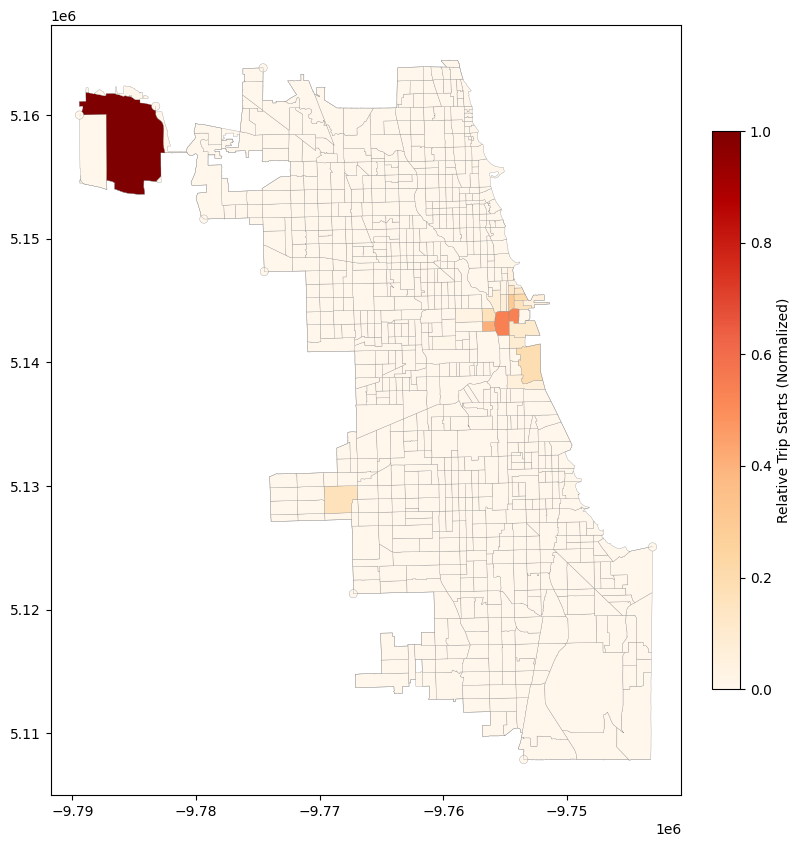

In [9]:
# base plot
fig, ax = plt.subplots(figsize=(10, 10))
choropleth = tracts_chi.plot(
    column='rel_demand', cmap='OrRd', linewidth=0.2, edgecolor='gray', ax=ax, legend=False
)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=tracts_chi['rel_demand'].min(), vmax=tracts_chi['rel_demand'].max()))
cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Relative Trip Starts (Normalized)')

In [ ]:
try:
    provider = ctx.providers.Stamen.TonerLite
except Exception:
    provider = ctx.providers.OpenStreetMap.Mapnik
ctx.add_basemap(ax, source=provider)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()

# Heatmap image placeholder
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.zeros((bins, bins)).T, extent=extent, origin='lower', alpha=0.5)

def update(frame_hour):
    H, xedges, yedges = hourly_H[frame_hour]
    im.set_data(H.T)
    ax.set_title(f'Hour: {frame_hour:02d}:00 - Chicago Taxi Demand', fontsize=15)
    return [im]

In [ ]:
ani = FuncAnimation(fig, update, frames=range(24), blit=True, repeat=True)

# To save animation as mp4:
# ani.save('taxi_demand_24h.mp4', writer='ffmpeg', fps=2)

# To display in notebook or interactive window
plt.show()